In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import random
from tqdm import tqdm
import cv2
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [3]:
TRAIN_PATH = "dataset/2d_slices/data_for_model/train/pre_processed_images"
TRAIN_MASK_PATH = "dataset/2d_slices/data_for_model/train/masks"

In [4]:
train_ids = next(os.walk(TRAIN_PATH))[2]
mask_train_ids = next(os.walk(TRAIN_MASK_PATH))[2]

In [5]:
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

In [6]:
X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(mask_train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype = np.float16)

In [7]:
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path=TRAIN_PATH+"/"+id_
    img = np.load(path)
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    X_train[n]=np.expand_dims(img, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:20<00:00, 74.43it/s]


In [8]:
for n,id_ in tqdm(enumerate(mask_train_ids),total=len(mask_train_ids)):
    path=TRAIN_MASK_PATH+"/"+id_
    mask = np.load(path)
    mask = resize(mask,(IMG_HEIGHT,IMG_WIDTH),mode="constant",preserve_range=True)
    Y_train[n]=np.expand_dims(mask, axis=2)

100%|██████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:22<00:00, 67.45it/s]


C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


Smallest pixel in image is [0]
Largest pixel in image is [254]
Smallest pixel in mask is [0.]
Largest pixel in mask is [1.]


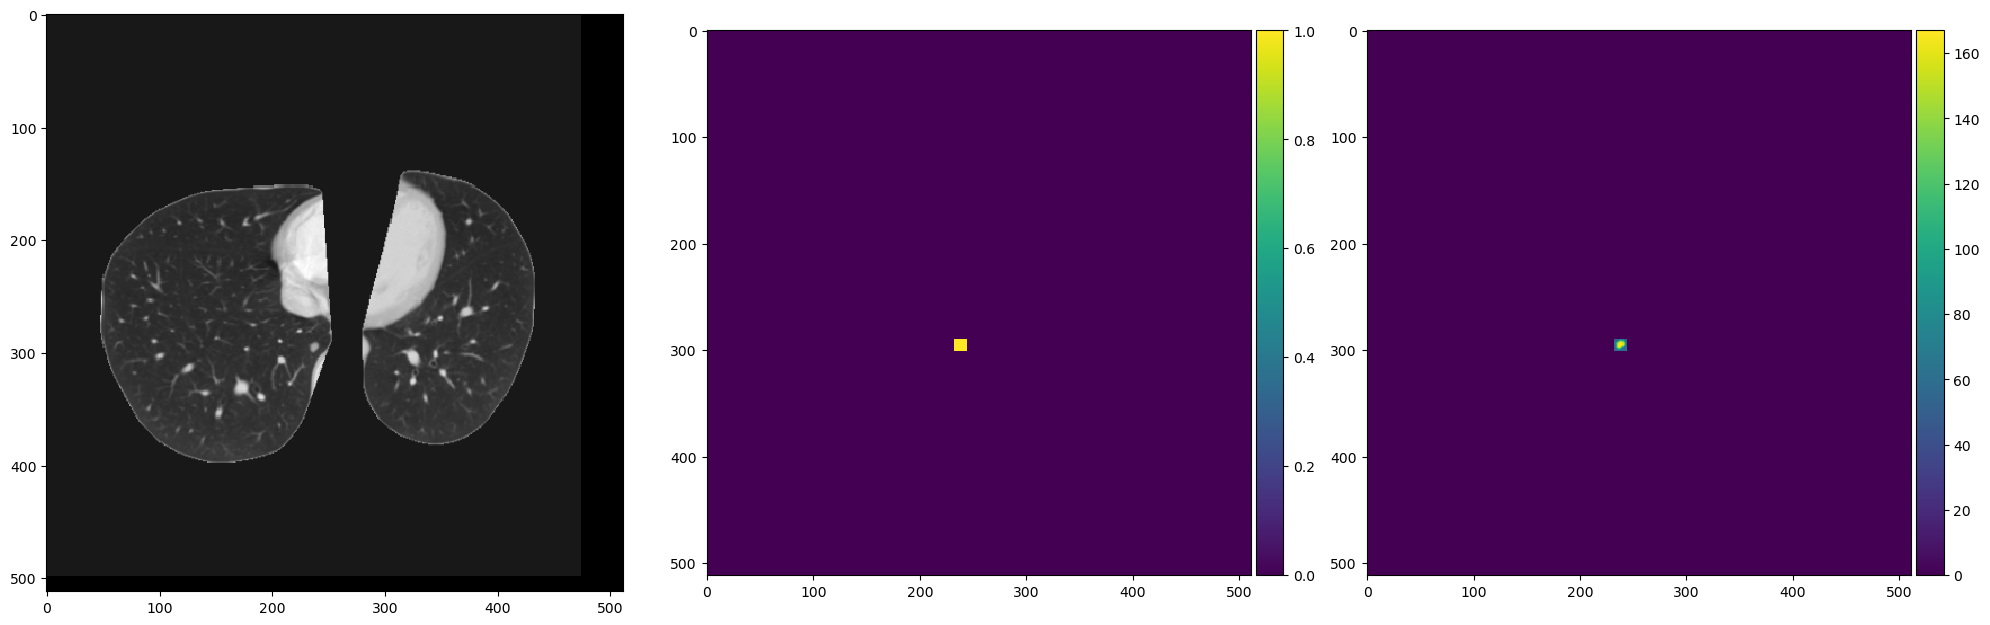

In [9]:
#Checking the training data
ix=random.randint(0,len(train_ids))
plt.figure(figsize=[20,10])
plt.subplot(131)
imshow(X_train[ix])
plt.subplot(132)
imshow(Y_train[ix])
plt.subplot(133)
imshow((X_train[ix])*Y_train[ix])
smallest = X_train[ix].min(axis=(0, 1))
largest = X_train[ix].max(axis=(0, 1))
print("Smallest pixel in image is",smallest)
print("Largest pixel in image is", largest)
smallest = Y_train[ix].min(axis=(0, 1))
largest = Y_train[ix].max(axis=(0, 1))
print("Smallest pixel in mask is",smallest)
print("Largest pixel in mask is", largest)


In [10]:
#https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
# def dice_coef(y_true, y_pred, smooth = 100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice
def dice_coef(y_true, y_pred, smooth = 1e-5):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice_scores_tensor = (2. * intersection + smooth) / (union + smooth)
    mean_dice_score = tf.reduce_mean(dice_scores_tensor)
    return mean_dice_score

In [11]:
def dice_coef_loss_and_bce(y_true, y_pred):
    dice_loss = 1- dice_coef(y_true, y_pred) 
#     y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
#     term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
#     term_1 = y_true * K.log(y_pred + K.epsilon())
#     bce_loss = -K.mean(term_0 + term_1)
#     mean = 0.8*(dice_loss) + 0.2*(bce_loss)
    return dice_loss

In [12]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS),dtype=tf.float32)

In [13]:
s = tf.keras.layers.Lambda(lambda x:x / 255)(inputs)

In [14]:
channel_multipler = 1

### Constructing U NET

In [15]:
c1 = tf.keras.layers.Conv2D(16*channel_multipler,(3,3),activation="relu",kernel_initializer = "he_normal",padding="same")(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)

In [16]:
c2=tf.keras.layers.Conv2D(32*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)

In [17]:
c3=tf.keras.layers.Conv2D(64*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(64*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

In [18]:
c4=tf.keras.layers.Conv2D(128*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(128*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

In [19]:
c5=tf.keras.layers.Conv2D(256*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c5)

In [20]:
#expansive path

In [21]:
u6 = tf.keras.layers.Conv2DTranspose(128*channel_multipler,(2,2),strides=(2,2),padding="same")(c5)
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(128*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c6)

In [22]:
u7=tf.keras.layers.Conv2DTranspose(64*channel_multipler,(2,2),strides=(2,2),padding="same")(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c7)

In [23]:
u8 = tf.keras.layers.Conv2DTranspose(32*channel_multipler,(2,2),strides=(2,2),padding="same")(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(32*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c8)


In [24]:
u9=tf.keras.layers.Conv2DTranspose(16*channel_multipler,(2,2),strides=(2,2),padding="same")(c8)
u9=tf.keras.layers.concatenate([u9,c1],axis=3)
c9=tf.keras.layers.Conv2D(16*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16*channel_multipler,(3,3),activation="relu",kernel_initializer="he_normal",padding="same")(c9)


In [25]:
outputs=tf.keras.layers.Conv2D(1,(1,1),activation="sigmoid")(c9)

In [26]:
#https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
model_unet=tf.keras.Model(inputs=[inputs],outputs=[outputs])
model_unet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00003),loss=dice_coef_loss_and_bce,metrics=[dice_coef])
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 256, 256, 32  8224       ['conv2d_13[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'conv2d_3[0][0]']               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_7

C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [27]:
checkpointer= tf.keras.callbacks.ModelCheckpoint("./lungnodule_augmentation.h5",verbose=1,save_best_only=True)

In [28]:
callbacks=[
    #tf.keras.callbacks.EarlyStopping(patience=20,monitor="dice_coef"),
    tf.keras.callbacks.TensorBoard(log_dir="logs"),
    checkpointer
]

In [ ]:
 results = model_unet.fit(X_train,Y_train,validation_split=0.2,batch_size=2,epochs=130,callbacks=callbacks )

Epoch 1/130
600/600 [==============================] - ETA: 0s - loss: 0.9851 - dice_coef: 0.0149
Epoch 1: val_loss improved from inf to 0.98521, saving model to .\lungnodule_augmentation.h5
600/600 [==============================] - 178s 287ms/step - loss: 0.9851 - dice_coef: 0.0149 - val_loss: 0.9852 - val_dice_coef: 0.0148
Epoch 2/130
600/600 [==============================] - ETA: 0s - loss: 0.9471 - dice_coef: 0.0532
Epoch 2: val_loss improved from 0.98521 to 0.84567, saving model to .\lungnodule_augmentation.h5
600/600 [==============================] - 257s 429ms/step - loss: 0.9471 - dice_coef: 0.0532 - val_loss: 0.8457 - val_dice_coef: 0.1543
Epoch 3/130
600/600 [==============================] - ETA: 0s - loss: 0.8845 - dice_coef: 0.1154
Epoch 3: val_loss did not improve from 0.84567
600/600 [==============================] - 252s 420ms/step - loss: 0.8845 - dice_coef: 0.1154 - val_loss: 0.8525 - val_dice_coef: 0.1475
Epoch 4/130
600/600 [==============================] - ETA

Epoch 28/130
600/600 [==============================] - ETA: 0s - loss: 0.6041 - dice_coef: 0.3963
Epoch 28: val_loss did not improve from 0.61408
600/600 [==============================] - 181s 302ms/step - loss: 0.6041 - dice_coef: 0.3963 - val_loss: 0.7054 - val_dice_coef: 0.2946
Epoch 29/130
600/600 [==============================] - ETA: 0s - loss: 0.5902 - dice_coef: 0.4100
Epoch 29: val_loss did not improve from 0.61408
600/600 [==============================] - 167s 279ms/step - loss: 0.5902 - dice_coef: 0.4100 - val_loss: 0.6472 - val_dice_coef: 0.3528
Epoch 30/130
600/600 [==============================] - ETA: 0s - loss: 0.5809 - dice_coef: 0.4195
Epoch 30: val_loss did not improve from 0.61408
600/600 [==============================] - 172s 286ms/step - loss: 0.5809 - dice_coef: 0.4195 - val_loss: 0.6565 - val_dice_coef: 0.3435
Epoch 31/130
600/600 [==============================] - ETA: 0s - loss: 0.5848 - dice_coef: 0.4148
Epoch 31: val_loss improved from 0.61408 to 0.608

Epoch 56/130
600/600 [==============================] - ETA: 0s - loss: 0.4989 - dice_coef: 0.5007
Epoch 56: val_loss did not improve from 0.55295
600/600 [==============================] - 191s 319ms/step - loss: 0.4989 - dice_coef: 0.5007 - val_loss: 0.5699 - val_dice_coef: 0.4301
Epoch 57/130
600/600 [==============================] - ETA: 0s - loss: 0.4871 - dice_coef: 0.5124
Epoch 57: val_loss did not improve from 0.55295
600/600 [==============================] - 183s 304ms/step - loss: 0.4871 - dice_coef: 0.5124 - val_loss: 0.5650 - val_dice_coef: 0.4350
Epoch 58/130
600/600 [==============================] - ETA: 0s - loss: 0.4864 - dice_coef: 0.5138
Epoch 58: val_loss did not improve from 0.55295
600/600 [==============================] - 199s 331ms/step - loss: 0.4864 - dice_coef: 0.5138 - val_loss: 0.5583 - val_dice_coef: 0.4417
Epoch 59/130
600/600 [==============================] - ETA: 0s - loss: 0.5000 - dice_coef: 0.5002
Epoch 59: val_loss did not improve from 0.55295
6

600/600 [==============================] - 261s 435ms/step - loss: 0.4460 - dice_coef: 0.5536 - val_loss: 0.5669 - val_dice_coef: 0.4331
Epoch 84/130
600/600 [==============================] - ETA: 0s - loss: 0.4396 - dice_coef: 0.5605
Epoch 84: val_loss did not improve from 0.53002
600/600 [==============================] - 191s 319ms/step - loss: 0.4396 - dice_coef: 0.5605 - val_loss: 0.5342 - val_dice_coef: 0.4658
Epoch 85/130
600/600 [==============================] - ETA: 0s - loss: 0.4382 - dice_coef: 0.5620
Epoch 85: val_loss did not improve from 0.53002
600/600 [==============================] - 215s 358ms/step - loss: 0.4382 - dice_coef: 0.5620 - val_loss: 0.5480 - val_dice_coef: 0.4520
Epoch 86/130
600/600 [==============================] - ETA: 0s - loss: 0.4463 - dice_coef: 0.5538
Epoch 86: val_loss did not improve from 0.53002
600/600 [==============================] - 179s 298ms/step - loss: 0.4463 - dice_coef: 0.5538 - val_loss: 0.5331 - val_dice_coef: 0.4669
Epoch 87/13

600/600 [==============================] - 218s 364ms/step - loss: 0.4079 - dice_coef: 0.5923 - val_loss: 0.5241 - val_dice_coef: 0.4759
Epoch 112/130
600/600 [==============================] - ETA: 0s - loss: 0.4094 - dice_coef: 0.5908
Epoch 112: val_loss improved from 0.52182 to 0.52065, saving model to .\lungnodule_augmentation.h5
600/600 [==============================] - 196s 327ms/step - loss: 0.4094 - dice_coef: 0.5908 - val_loss: 0.5206 - val_dice_coef: 0.4794
Epoch 113/130
207/600 [=========>....................] - ETA: 1:59 - loss: 0.3823 - dice_coef: 0.6177

In [ ]:
dice_coef = results.history['dice_coef']
val_dice_coef = results.history['val_dice_coef']
loss = results.history['loss']
val_loss = results.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(dice_coef) + 1)

plt.plot(epochs, dice_coef, 'b', label='Training dice coefficent',color="green")
plt.plot(epochs, val_dice_coef, 'b', label='Validation dice coefficient',color="blue")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.savefig('vanilla_train_diceloss_bs32.png')
plt.plot(epochs, loss, 'b', label='Training loss',color="green")
plt.plot(epochs, val_loss, 'b', label='Validation loss',color="blue")
plt.title('Training and validation loss')
plt.legend()
plt.savefig('vanilla_loss_diceloss_bs32.png')

plt.show()

### Checking Prediction on Test Data set

In [ ]:
model_unet=tf.keras.models.load_model("lungnodule_vanilla_higher_epoch.h5",compile=False)

In [ ]:
y_pred=model_unet.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [ ]:
intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
dice_score = (2*np.sum(intersection)) / np.sum(union)
print("Dice score on test dataset is: ", dice_score)

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model_unet.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()